In [227]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (train_test_split, 
                                     GridSearchCV)
from sklearn.feature_extraction import DictVectorizer

from sklearn.metrics import (accuracy_score, 
                             precision_score, 
                             recall_score, 
                             f1_score,
                             roc_auc_score,
                             roc_curve,
                             auc,
                             confusion_matrix,
                             classification_report,
                             precision_recall_curve)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

%matplotlib inline

In [241]:
data = pd.read_csv(r"data/diabetes_prediction_dataset.csv")

df = data.copy()
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [242]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [230]:
df.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history',
       'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes'],
      dtype='object')

In [243]:
for col in df.columns:
    print(col)
    print(df[col].unique(), '\n')

gender
['Female' 'Male' 'Other'] 

age
[80.   54.   28.   36.   76.   20.   44.   79.   42.   32.   53.   78.
 67.   15.   37.   40.    5.   69.   72.    4.   30.   45.   43.   50.
 41.   26.   34.   73.   77.   66.   29.   60.   38.    3.   57.   74.
 19.   46.   21.   59.   27.   13.   56.    2.    7.   11.    6.   55.
  9.   62.   47.   12.   68.   75.   22.   58.   18.   24.   17.   25.
  0.08 33.   16.   61.   31.    8.   49.   39.   65.   14.   70.    0.56
 48.   51.   71.    0.88 64.   63.   52.    0.16 10.   35.   23.    0.64
  1.16  1.64  0.72  1.88  1.32  0.8   1.24  1.    1.8   0.48  1.56  1.08
  0.24  1.4   0.4   0.32  1.72  1.48] 

hypertension
[0 1] 

heart_disease
[1 0] 

smoking_history
['never' 'No Info' 'current' 'former' 'ever' 'not current'] 

bmi
[25.19 27.32 23.45 ... 59.42 44.39 60.52] 

HbA1c_level
[6.6 5.7 5.  4.8 6.5 6.1 6.  5.8 3.5 6.2 4.  4.5 9.  7.  8.8 8.2 7.5 6.8] 

blood_glucose_level
[140  80 158 155  85 200 145 100 130 160 126 159  90 260 220 300 280 2

In [245]:
len(df[df.gender == 'Other'])

18

In [246]:
df = df[df['gender'] != 'Other']

In [247]:
df['gender'] = df['gender'].map({'Male': 1, 'Female': 0})

In [248]:
df['smoking_history'] = df['smoking_history'].replace('No Info', 'unknown')

In [249]:
df['age_raw'] = df['age']
df['bmi_raw'] = df['bmi']
df['glucose_raw'] = df['blood_glucose_level']
df['HbA1c_raw'] = df['HbA1c_level']

num_cols = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']
scaler = StandardScaler()

df[num_cols] = scaler.fit_transform(df[num_cols])

df['bmi_per_age'] = df['bmi_raw'] / df['age_raw']
df['glucose_HbA1c_ratio'] = df['glucose_raw'] / df['HbA1c_raw']
df['is_elderly'] = (df['age_raw'] > 60).astype(int)
df['is_obese'] = (df['bmi_raw'] >= 30).astype(int)

In [250]:
for col in df.columns:
    print(col)
    print(df[col].unique(), '\n')

gender
[0 1] 

age
[ 1.6925774   0.53789908 -0.61677923 -0.2614936   1.51493458 -0.97206487
  0.09379204  1.64816669  0.00497063 -0.43913641  0.49348838  1.60375599
  1.11523824 -1.19411839 -0.21708289 -0.08385078 -1.63822543  1.20405965
  1.33729176 -1.68263614 -0.52795782  0.13820274  0.04938133  0.36025627
 -0.03944007 -0.70560064 -0.35031501  1.38170247  1.55934529  1.07082754
 -0.57236853  0.80436331 -0.17267219 -1.72704684  0.6711312   1.42611317
 -1.01647557  0.18261345 -0.92765416  0.75995261 -0.66118994 -1.2829398
  0.62672049 -1.77145755 -1.54940403 -1.37176121 -1.59381473  0.58230979
 -1.46058262  0.89318472  0.22702415 -1.3273505   1.15964895  1.47052388
 -0.88324346  0.7155419  -1.06088628 -0.79442205 -1.10529698 -0.75001135
 -1.8567261  -0.39472571 -1.14970769  0.84877401 -0.48354712 -1.50499332
  0.31584556 -0.12826148  1.02641683 -1.23852909  1.24847035 -1.83540896
  0.27143486  0.40466697  1.29288106 -1.82119754  0.98200613  0.93759542
  0.44907767 -1.85317324 -1.41617

### EDA

<Axes: xlabel='diabetes', ylabel='count'>

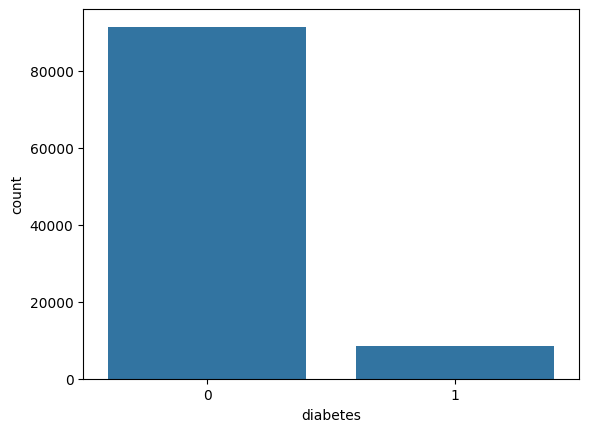

In [251]:
sns.countplot(x='diabetes', data=df)

In [252]:
class_counts = df['diabetes'].value_counts()
class_percentages = df['diabetes'].value_counts(normalize=True) * 100

print("Class distribution:")
print(class_counts)
print("\nClass percentage:")
print(class_percentages)

Class distribution:
diabetes
0    91482
1     8500
Name: count, dtype: int64

Class percentage:
diabetes
0    91.49847
1     8.50153
Name: proportion, dtype: float64


-- Dataset has class imbalance which needs to be dealed with to avoid overfitting to only class 

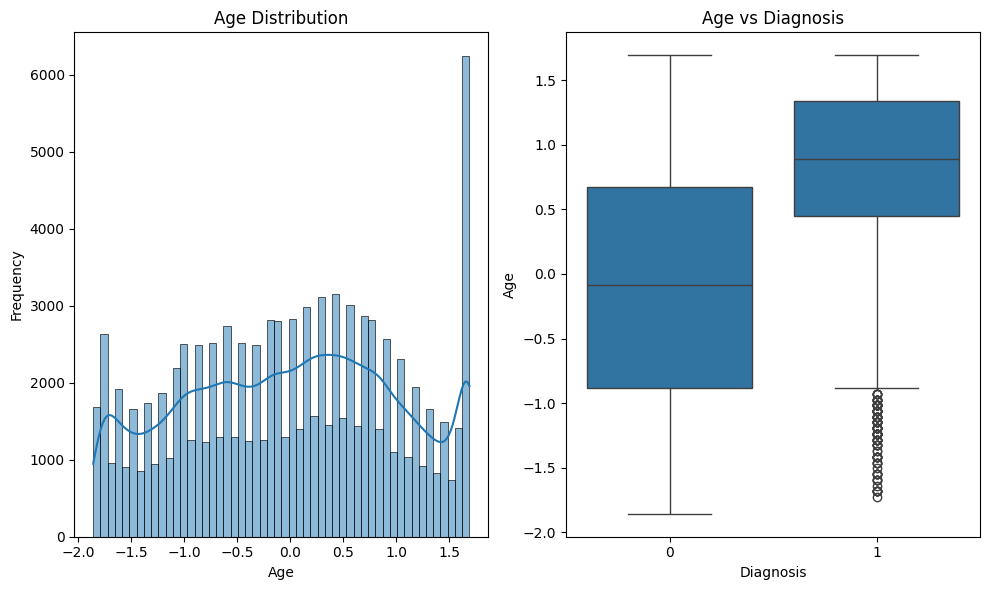

In [253]:
# Age vs Diabetes
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
sns.histplot(df.age, kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.boxplot(x='diabetes', y='age', data=df)
plt.title('Age vs Diagnosis')
plt.xlabel('Diagnosis')
plt.ylabel('Age')
plt.tight_layout()
plt.show()

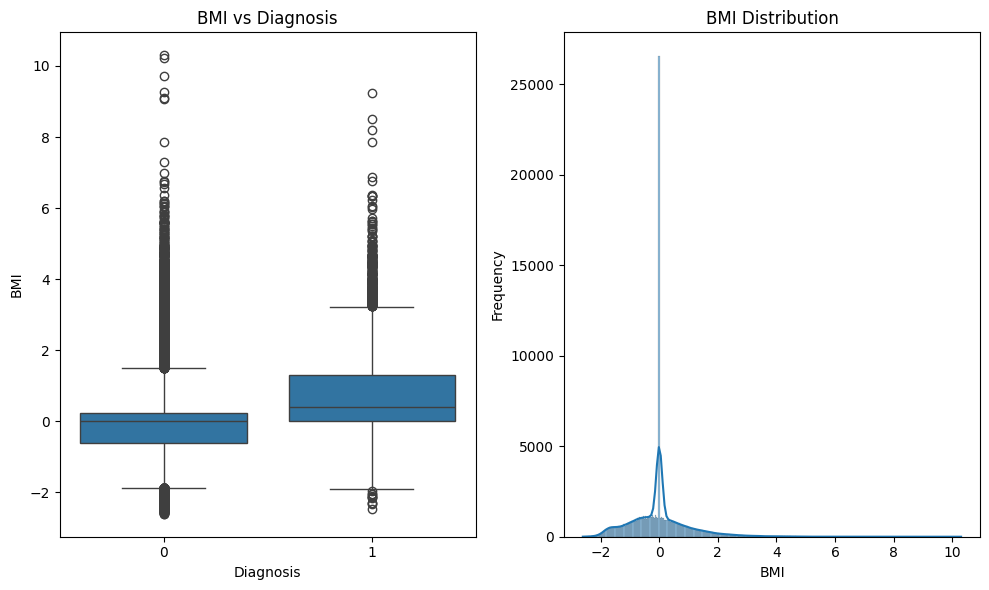

In [254]:
# BMI vs Diabetes
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x='diabetes', y='bmi', data=df)
plt.title('BMI vs Diagnosis')
plt.xlabel('Diagnosis')
plt.ylabel('BMI')

plt.subplot(1, 2, 2)
sns.histplot(df.bmi, kde=True)
plt.title('BMI Distribution')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

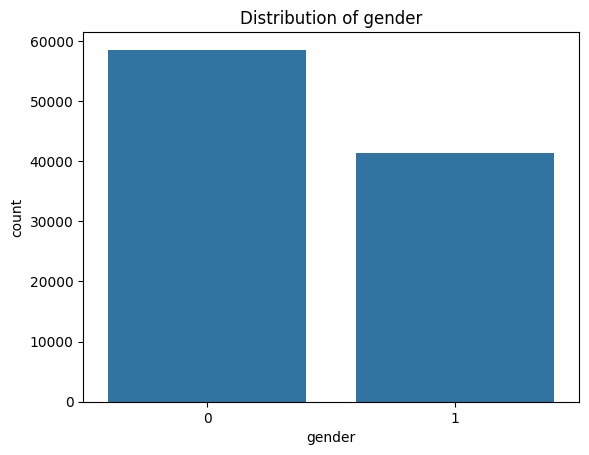

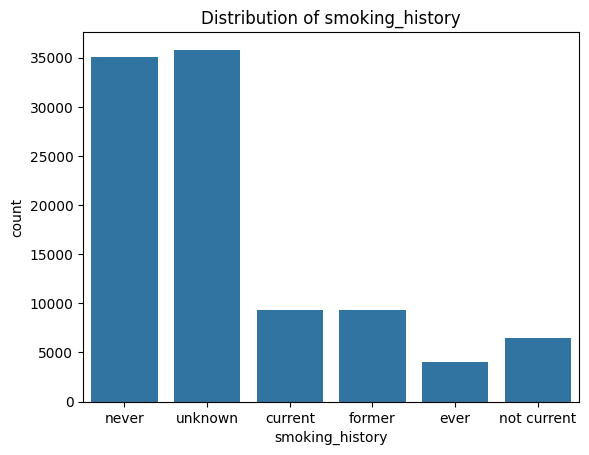

In [255]:
for col in ['gender', 'smoking_history']:
    sns.countplot(data=df, x=col)
    plt.title(f'Distribution of {col}')
    plt.show()

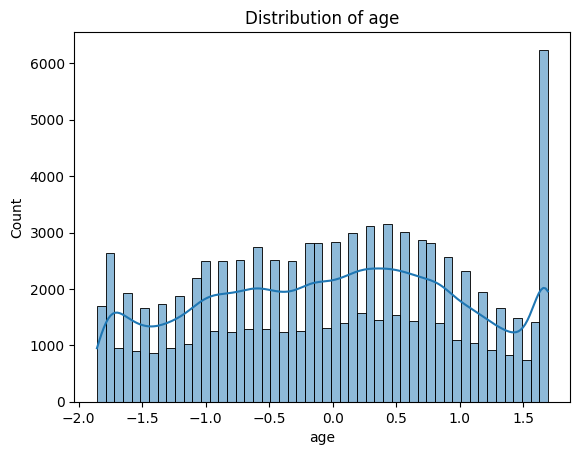

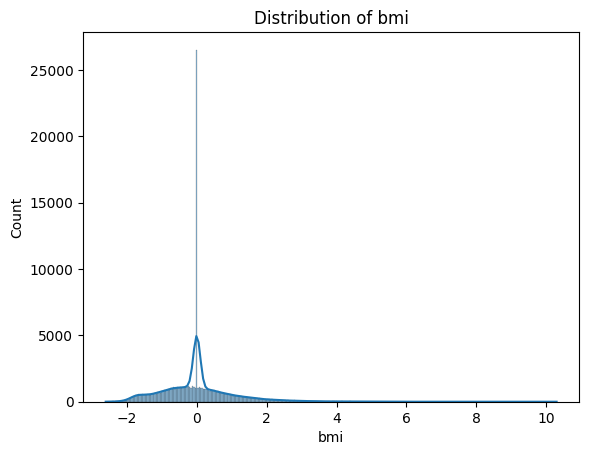

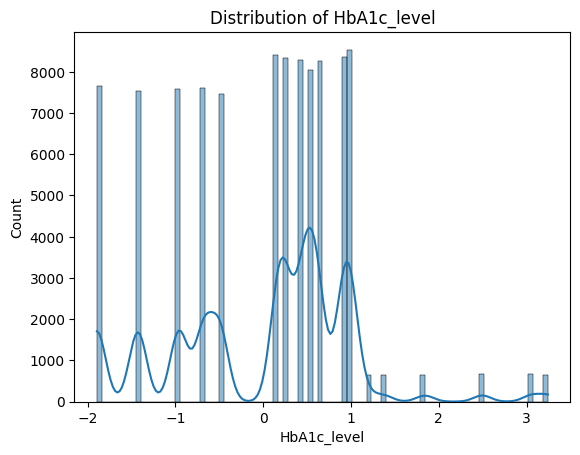

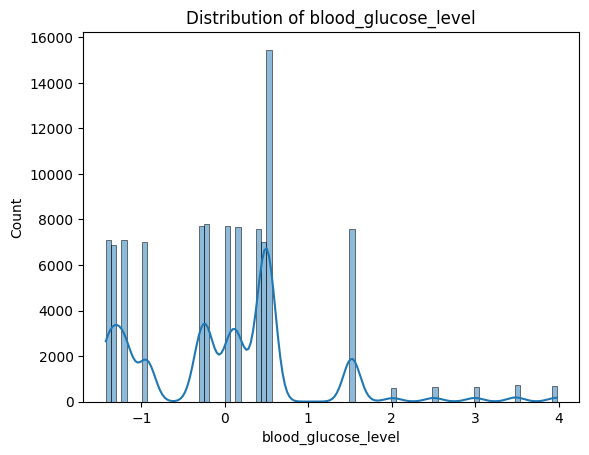

In [256]:
for col in numeric_features:
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

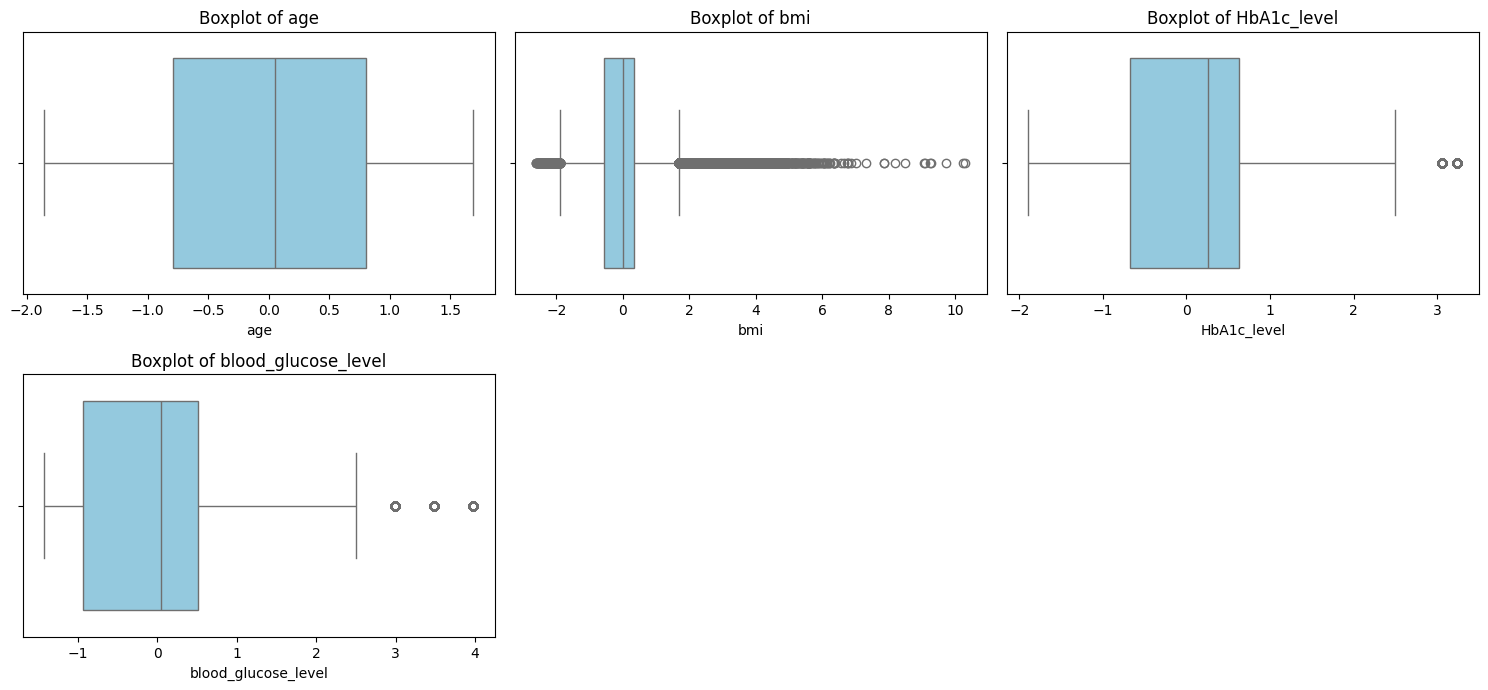

In [261]:
plt.figure(figsize=(15, 10))

for i, col in enumerate(numeric_features, 1):
    plt.subplot(3, 3, i)  
    sns.boxplot(x=df[col], color='skyblue')
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)

plt.tight_layout()
plt.show()

In [262]:
def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    cleaned_data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]
    return cleaned_data

In [263]:
cols_to_clean = ['bmi', 'HbA1c_level', 'blood_glucose_level']


df_cleaned = df.copy()
for col in cols_to_clean:
    df_cleaned = remove_outliers_iqr(df_cleaned, col)

print(f"Original dataset shape: {df.shape}")
print(f"After outlier removal: {df_cleaned.shape}")

Original dataset shape: (99982, 17)
After outlier removal: (90370, 17)


In [264]:
class_counts = df_cleaned['diabetes'].value_counts()
class_percentages = df_cleaned['diabetes'].value_counts(normalize=True) * 100

print("Class distribution:")
print(class_counts)
print("\nClass percentage:")
print(class_percentages)

Class distribution:
diabetes
0    85875
1     4495
Name: count, dtype: int64

Class percentage:
diabetes
0    95.026004
1     4.973996
Name: proportion, dtype: float64


In [265]:
df_encoded = pd.get_dummies(df, drop_first=True)
df_encoded.corr()['diabetes'].sort_values(ascending=False)

diabetes                       1.000000
glucose_raw                    0.419587
blood_glucose_level            0.419587
HbA1c_level                    0.400696
HbA1c_raw                      0.400696
age_raw                        0.257999
age                            0.257999
is_elderly                     0.228742
bmi_raw                        0.214377
bmi                            0.214377
hypertension                   0.197811
is_obese                       0.188733
heart_disease                  0.171718
smoking_history_former         0.097901
glucose_HbA1c_ratio            0.097456
gender                         0.037623
smoking_history_never          0.027248
smoking_history_ever           0.024088
smoking_history_not current    0.020831
bmi_per_age                   -0.050988
smoking_history_unknown       -0.118953
Name: diabetes, dtype: float64

In [266]:
df_train, df_test = train_test_split(df_cleaned, test_size=0.2, random_state=11)

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.diabetes.values
y_test = df_test.diabetes.values

del df_train['diabetes']
del df_test['diabetes']

In [267]:
df_train.shape, df_test.shape, y_train.shape, y_test.shape

((72296, 16), (18074, 16), (72296,), (18074,))

In [268]:
train_dicts = df_train.fillna(0).to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

In [269]:
test_dicts = df_test.fillna(0).to_dict(orient='records')
X_test = dv.transform(test_dicts)

In [270]:
X_train.shape, X_test.shape

((72296, 21), (18074, 21))

In [271]:
pd.Series(y_train).value_counts()


0    68733
1     3563
Name: count, dtype: int64

In [272]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [273]:
pd.Series(y_train_resampled).value_counts()

0    68733
1    68733
Name: count, dtype: int64

In [274]:
model = LogisticRegression()
model.fit(X_train_resampled, y_train_resampled)

/mnt/d/data-engineering/machine_learning_projects/loan-approval-prediction/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [275]:
y_pred = model.predict_proba(X_test)[:,1]
y_pred

array([2.70857060e-01, 4.79152799e-02, 4.33120921e-04, ...,
       5.38628212e-04, 7.20345042e-02, 9.86129524e-01], shape=(18074,))

In [276]:
((y_pred > 0.5) == y_test).mean()

np.float64(0.8462985504038951)

In [277]:
result_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC'])

In [278]:
def metrics(y_true, y_pred, model):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_true, y_pred)
    print('Classification Report:')
    print(classification_report(y_true, y_pred))
    print('Accuracy:', acc)
    print('Precision:', prec)
    print('Recall:', rec)
    print('F1 Score:', f1)
    print('ROC AUC Score:', roc_auc)

    return acc, prec, rec, f1, roc_auc, fpr, tpr

def plot_curve_mat(fpr, tpr, y_true, y_pred):
    plt.figure(figsize=(20, 6))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.subplot(1, 2, 2)
    confusion_mat=confusion_matrix(y_true, y_pred)
    sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

### LogisticRegression

In [314]:

# Grid searching of LogisticRegression for the parameters for the resampled
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'] 
}

grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, scoring='f1')
grid.fit(X_train_resampled, y_train_resampled)

print("Best parameters:", grid.best_params_)


Best parameters: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}


In [315]:
best_params = grid.best_params_
best_params

{'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}

/mnt/d/data-engineering/machine_learning_projects/loan-approval-prediction/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.85      0.91     17142
           1       0.24      0.89      0.37       932

    accuracy                           0.85     18074
   macro avg       0.61      0.87      0.64     18074
weighted avg       0.95      0.85      0.89     18074

Accuracy: 0.8472944561248202
Precision: 0.23720529039677976
Recall: 0.8851931330472103
F1 Score: 0.3741496598639456
ROC AUC Score: 0.8652135307051475


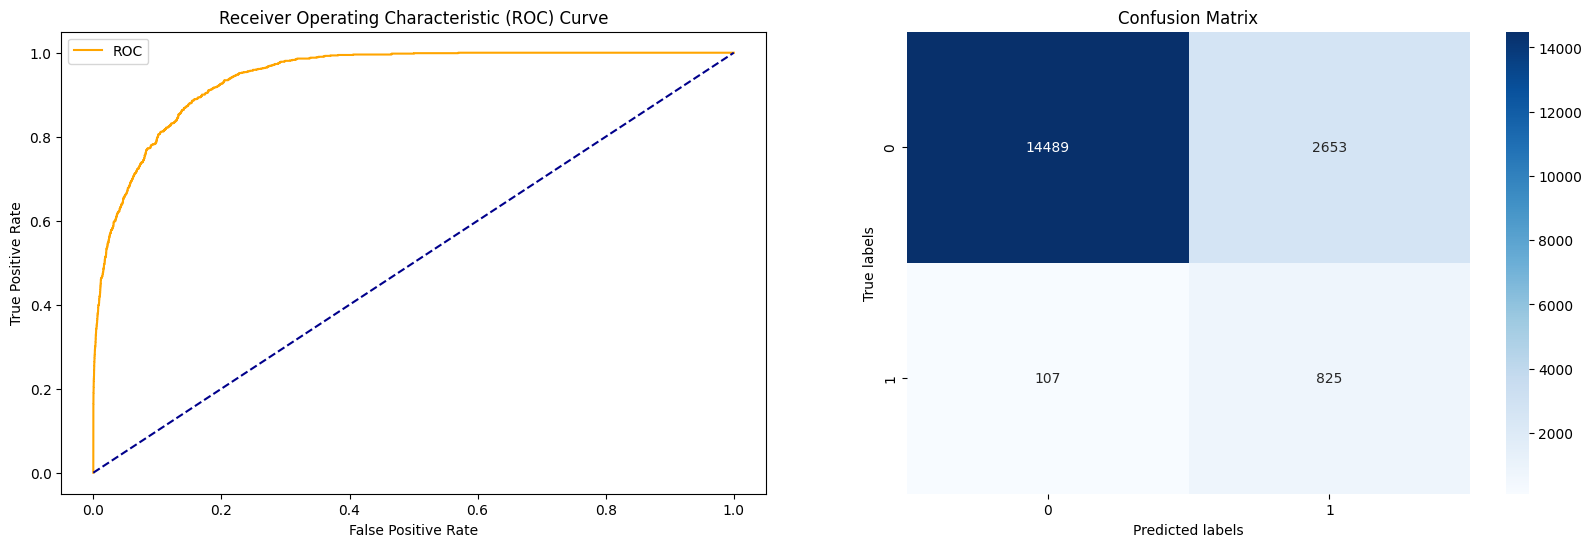

In [316]:
logreg = LogisticRegression(**best_params, random_state=42)
logreg.fit(X_train_resampled, y_train_resampled)
y_pred = logreg.predict(X_test)

acc, prec, rec, f1, roc_auc, fpr, tpr = metrics(y_test, y_pred, logreg)
plot_curve_mat(fpr, tpr, y_test, y_pred)

result_df.loc[len(result_df)] = ['Logistic Regression', acc, prec, rec, f1, roc_auc]

In [317]:
# Grid searching of LogisticRegression for the parameters for the un-resampled
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'] 
}

grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, scoring='f1')
grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)

Best parameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}


In [318]:
logreg_best_params = grid.best_params_
logreg_best_params

{'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     17142
           1       0.80      0.41      0.54       932

    accuracy                           0.96     18074
   macro avg       0.88      0.70      0.76     18074
weighted avg       0.96      0.96      0.96     18074

Accuracy: 0.96409206595109
Precision: 0.7966457023060797
Recall: 0.40772532188841204
F1 Score: 0.5393896380411639
ROC AUC Score: 0.7010333528121327


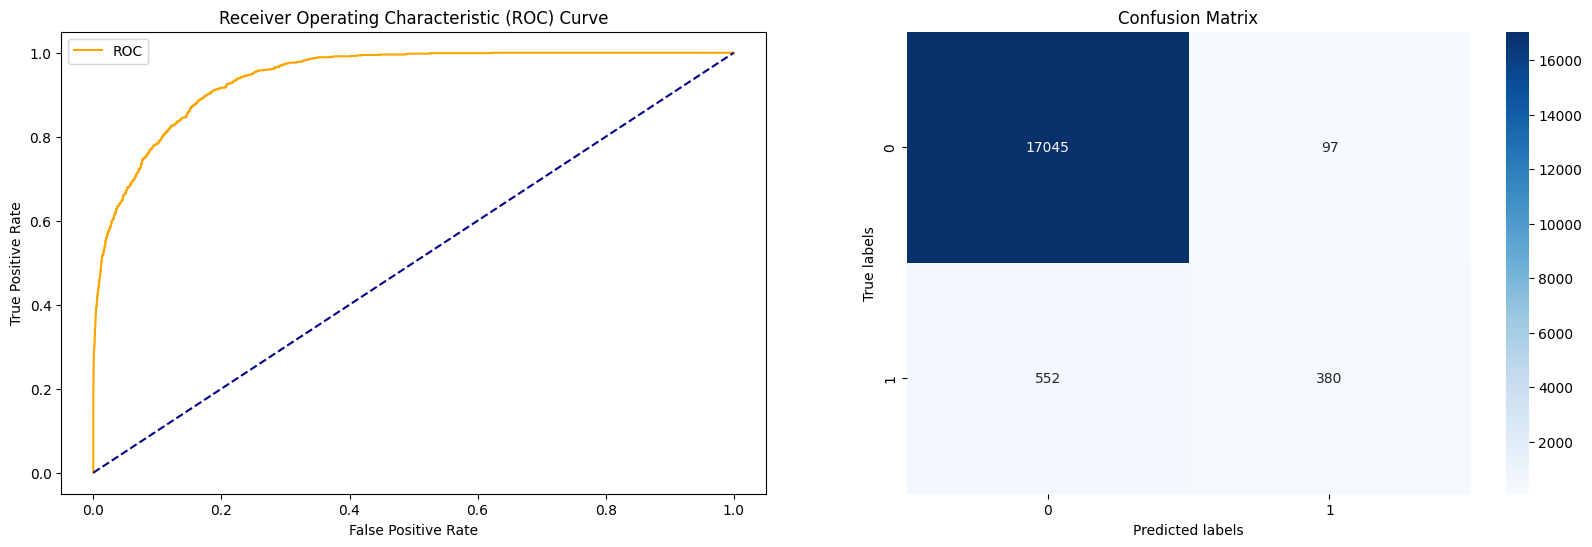

In [323]:
# un-resampled model
logreg_unresampled = LogisticRegression(**logreg_best_params, random_state=42)
logreg_unresampled.fit(X_train, y_train)
y_pred_unresampled = logreg_unresampled.predict(X_test)

acc_unresampled, prec_unresampled, rec_unresampled, f1_unresampled, roc_auc_unresampled, fpr_unresampled, tpr_unresampled = metrics(y_test, y_pred_unresampled, logreg_unresampled)
plot_curve_mat(fpr_unresampled, tpr_unresampled, y_test, y_pred_unresampled)

result_df.loc[len(result_df)] = ['Logistic Regression Unsampled', acc_unresampled, prec_unresampled, rec_unresampled, f1_unresampled, roc_auc_unresampled]

In [324]:
result_df

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Logistic Regression,0.847294,0.237205,0.885193,0.37415,0.865214
2,Logistic Regression Unsampled,0.964092,0.796646,0.407725,0.53939,0.701033


### DecisionTreeClassifier

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98     17142
           1       0.54      0.57      0.56       932

    accuracy                           0.95     18074
   macro avg       0.76      0.77      0.77     18074
weighted avg       0.95      0.95      0.95     18074

Accuracy: 0.953192431116521
Precision: 0.5436991869918699
Recall: 0.5740343347639485
F1 Score: 0.558455114822547
ROC AUC Score: 0.773920679224233


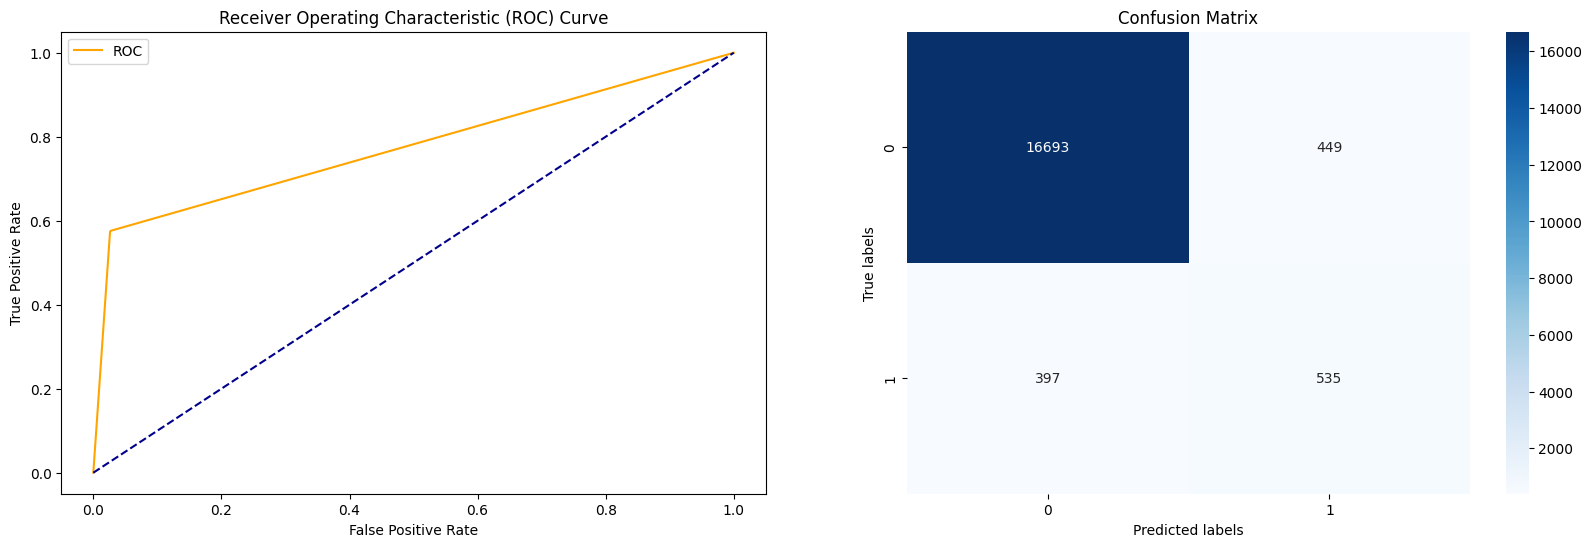

In [321]:
dt = DecisionTreeClassifier(random_state=42)

dt.fit(X_train_resampled, y_train_resampled)

y_pred = dt.predict(X_test)

acc, prec, rec, f1, roc_auc, fpr, tpr = metrics(y_test, y_pred, dt)
plot_curve_mat(fpr, tpr, y_test, y_pred)

result_df.loc[len(result_df)] = ['Decision Tree ', acc, prec, rec, f1, roc_auc]

In [306]:
# Grid searching of DescisionTree for the parameters
param_grid = {
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'criterion': ['gini', 'entropy']
}

grid = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='f1')
grid.fit(X_train_resampled, y_train_resampled)

print("Best parameters:", grid.best_params_)

Best parameters: {'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 10}


In [307]:
dt_best_params = grid.best_params_
dt_best_params

{'criterion': 'gini',
 'max_depth': 15,
 'min_samples_leaf': 1,
 'min_samples_split': 10}

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     17142
           1       0.65      0.55      0.60       932

    accuracy                           0.96     18074
   macro avg       0.81      0.77      0.79     18074
weighted avg       0.96      0.96      0.96     18074

Accuracy: 0.9617129578399911
Precision: 0.6511335012594458
Recall: 0.5547210300429185
F1 Score: 0.5990730011587485
ROC AUC Score: 0.7692809443762604


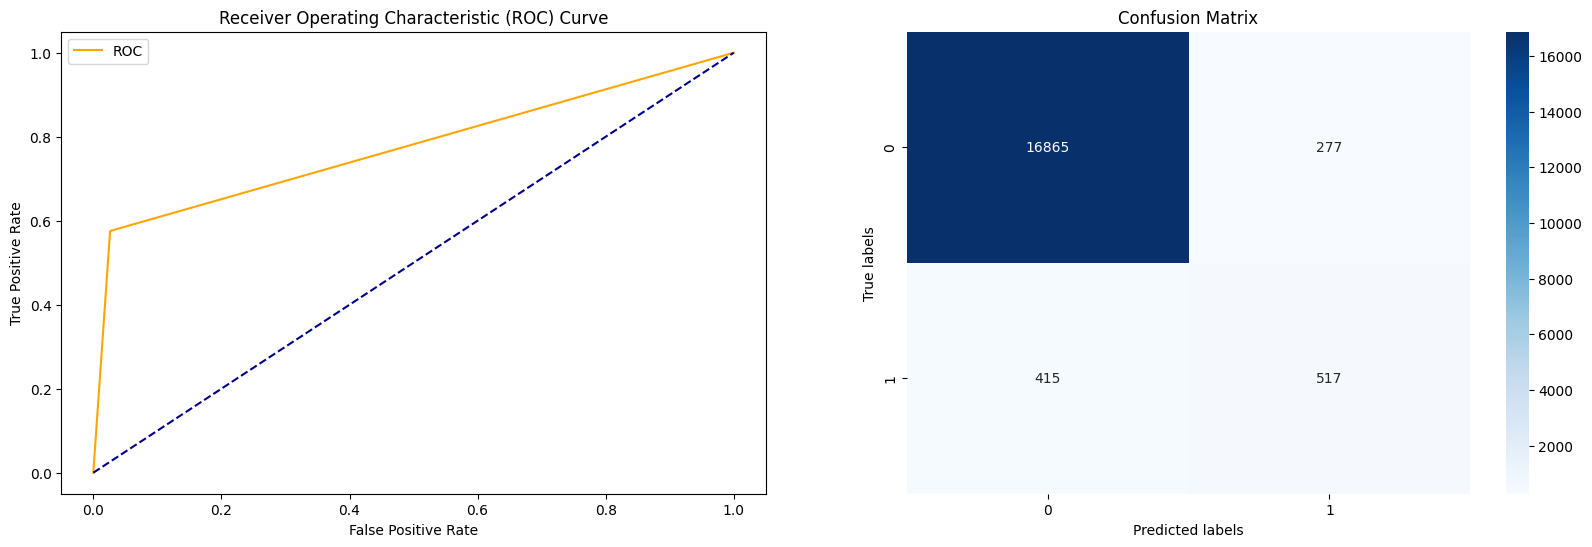

In [308]:
best_dt = DecisionTreeClassifier(**dt_best_params, random_state=42)

best_dt.fit(X_train_resampled, y_train_resampled)

y_pred = best_dt.predict(X_test)

acc, prec, rec, f1, roc_auc, fpr, tpr = metrics(y_test, y_pred, best_dt)
plot_curve_mat(fpr, tpr, y_test, y_pred)

result_df.loc[len(result_df)] = ['Decision Tree with parameter Tuning ', acc, prec, rec, f1, roc_auc]

In [328]:
result_df

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Logistic Regression,0.847294,0.237205,0.885193,0.374150,0.865214
1,Logistic Regression Unsampled,0.964092,0.796646,0.407725,0.539390,0.701033
2,Random Forest,0.969238,0.815436,0.521459,0.636126,0.757521


### RandomForest

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     17142
           1       0.82      0.52      0.64       932

    accuracy                           0.97     18074
   macro avg       0.89      0.76      0.81     18074
weighted avg       0.97      0.97      0.97     18074

Accuracy: 0.9692375788425363
Precision: 0.8154362416107382
Recall: 0.5214592274678111
F1 Score: 0.6361256544502618
ROC AUC Score: 0.7575211199758843


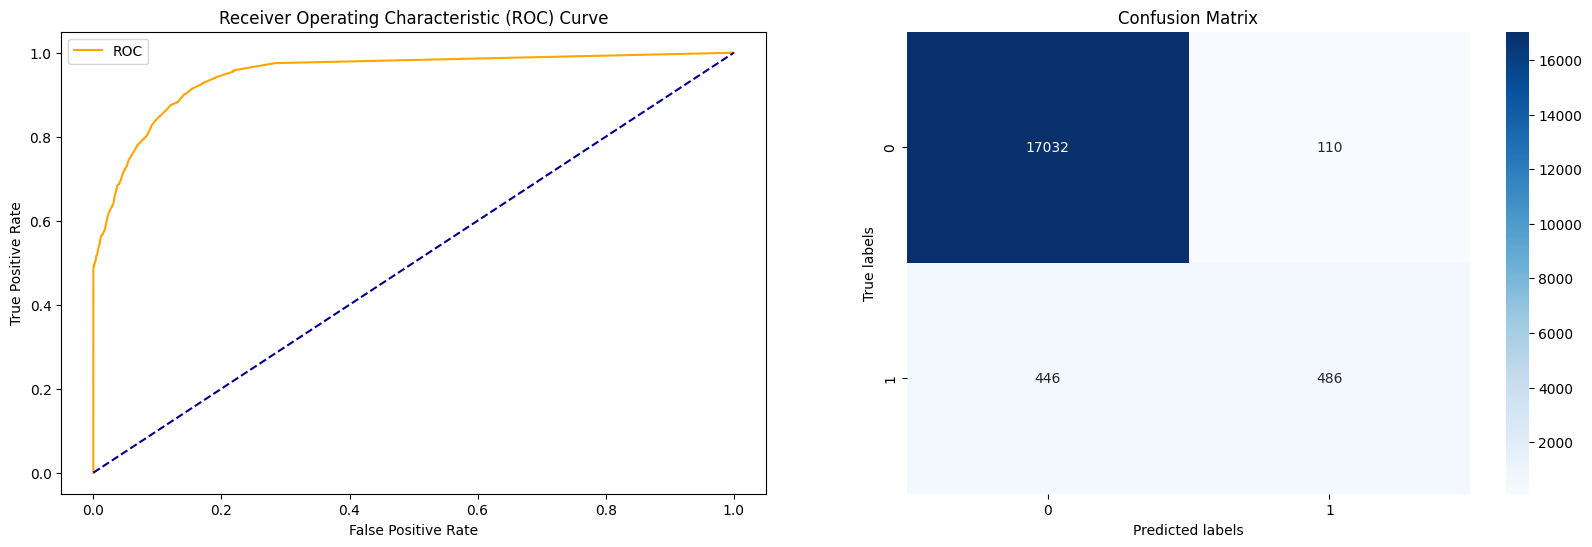

In [327]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_resampled, y_train_resampled)
y_pred = rf.predict(X_test)

acc, prec, rec, f1, roc_auc, fpr, tpr = metrics(y_test, y_pred, rf)
plot_curve_mat(fpr, tpr, y_test, y_pred)

result_df.loc[len(result_df)] = ['Random Forest', acc, prec, rec, f1, roc_auc]

In [329]:
# Grid Seaching for RandomForest parameters
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 4],
    'max_features': ['sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}

grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train_resampled, y_train_resampled)
print("Best parameters:", grid.best_params_)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}


In [330]:
rf_best_params = grid.best_params_
rf_best_params

{'criterion': 'entropy',
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 200}

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     17142
           1       0.85      0.51      0.64       932

    accuracy                           0.97     18074
   macro avg       0.91      0.75      0.81     18074
weighted avg       0.97      0.97      0.97     18074

Accuracy: 0.9701228283722474
Precision: 0.8487544483985765
Recall: 0.5118025751072961
F1 Score: 0.6385542168674698
ROC AUC Score: 0.7534219969224497


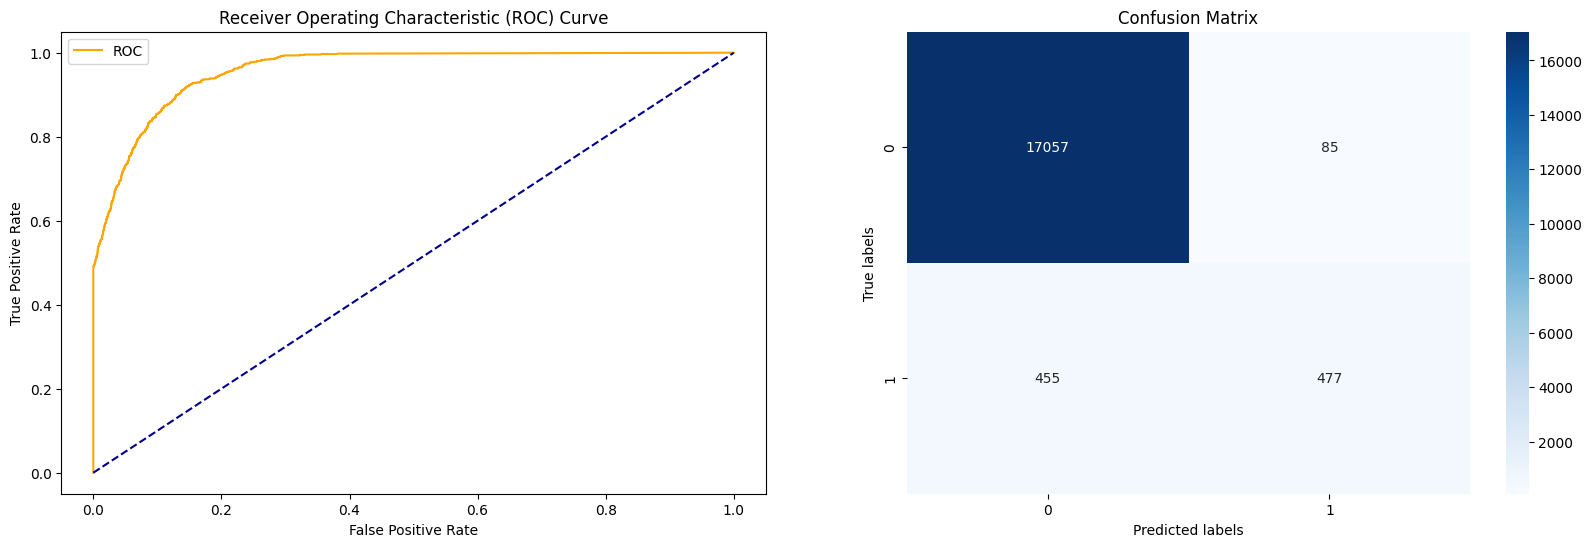

In [331]:
best_rf = RandomForestClassifier(**rf_best_params, random_state=42)
best_rf.fit(X_train_resampled, y_train_resampled)
y_pred = best_rf.predict(X_test)

acc, prec, rec, f1, roc_auc, fpr, tpr = metrics(y_test, y_pred, best_rf)
plot_curve_mat(fpr, tpr, y_test, y_pred)

result_df.loc[len(result_df)] = ['Random Forest with parameter Tuning ', acc, prec, rec, f1, roc_auc]

In [332]:
result_df

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Logistic Regression,0.847294,0.237205,0.885193,0.374150,0.865214
1,Logistic Regression Unsampled,0.964092,0.796646,0.407725,0.539390,0.701033
2,Random Forest,0.969238,0.815436,0.521459,0.636126,0.757521
3,Random Forest with parameter Tuning,0.970123,0.848754,0.511803,0.638554,0.753422


### Gradient Boosting

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     17142
           1       0.67      0.61      0.64       932

    accuracy                           0.96     18074
   macro avg       0.83      0.80      0.81     18074
weighted avg       0.96      0.96      0.96     18074

Accuracy: 0.9645346907159456
Precision: 0.6734207389749702
Recall: 0.6062231759656652
F1 Score: 0.6380575945793338
ROC AUC Score: 0.7951195217128524


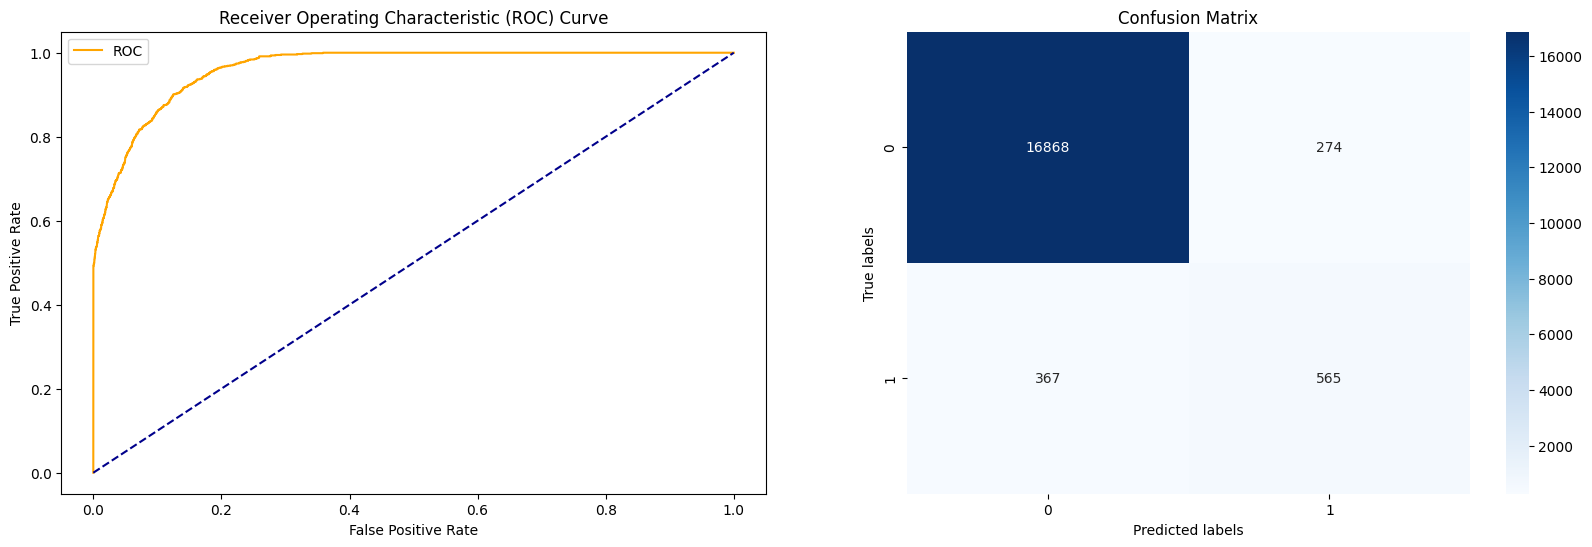

In [334]:
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train_resampled, y_train_resampled)
y_pred = gb.predict(X_test)

acc, prec, rec, f1, roc_auc, fpr, tpr = metrics(y_test, y_pred, gb)
plot_curve_mat(fpr, tpr, y_test, y_pred)

result_df.loc[len(result_df)] = ['Gradient Boosting ', acc, prec, rec, f1, roc_auc]

In [335]:
# Grid Seaching
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 4],
    'subsample': [0.8, 1.0],
    'max_features': ['sqrt', 'log2']
}

grid = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train_resampled, y_train_resampled)
print("Best parameters:", grid.best_params_)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200, 'subsample': 1.0}


In [336]:
gb_best_params = grid.best_params_
gb_best_params

{'learning_rate': 0.1,
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 200,
 'subsample': 1.0}

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     17142
           1       0.86      0.52      0.65       932

    accuracy                           0.97     18074
   macro avg       0.92      0.76      0.82     18074
weighted avg       0.97      0.97      0.97     18074

Accuracy: 0.9707867655195308
Precision: 0.8568904593639576
Recall: 0.5203862660944206
F1 Score: 0.6475300400534045
ROC AUC Score: 0.7578305149163037


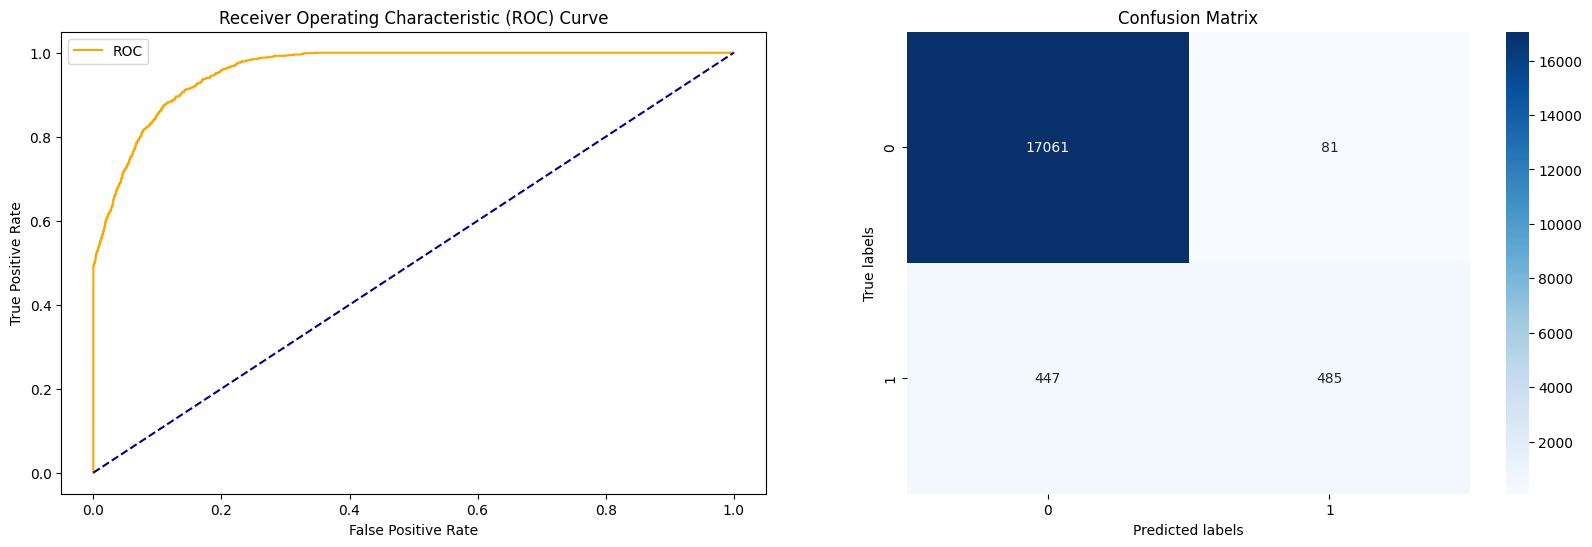

In [337]:
best_gb = GradientBoostingClassifier(**gb_best_params, random_state=42)
best_gb.fit(X_train_resampled, y_train_resampled)
y_pred = best_gb.predict(X_test)

acc, prec, rec, f1, roc_auc, fpr, tpr = metrics(y_test, y_pred, best_gb)
plot_curve_mat(fpr, tpr, y_test, y_pred)

result_df.loc[len(result_df)] = ['Gradient Boosting with parameter Tuning', acc, prec, rec, f1, roc_auc]

In [338]:
result_df

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Logistic Regression,0.847294,0.237205,0.885193,0.374150,0.865214
1,Logistic Regression Unsampled,0.964092,0.796646,0.407725,0.539390,0.701033
2,Random Forest,0.969238,0.815436,0.521459,0.636126,0.757521
3,Random Forest with parameter Tuning,0.970123,0.848754,0.511803,0.638554,0.753422
4,Gradient Boosting,0.964535,0.673421,0.606223,0.638058,0.795120
5,Gradient Boosting with parameter Tuning,0.970787,0.856890,0.520386,0.647530,0.757831
